# Regression Week 4: Ridge Regression Assignment 2
## Ridge regression via gradient descent

In this assignment, you will implement ridge regression via gradient descent. You will:
1. Convert an SFrame into a Numpy array
2. Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
3. Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.cross_validation import KFold
import zipfile
import os
import glob
from math import log
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

C:\Miniconda2\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


#### Extract all zips in the folder data sets

In [2]:
for root, dirs, files in os.walk("./datasets", topdown=False):
    zip_files = glob.glob(root + '/*.zip')
    print("Unzipping...")
    print(zip_files)
    for zip_filename in zip_files:
        dir_name = os.path.splitext(zip_filename)[0]
        zip_handler = zipfile.ZipFile(zip_filename, "r")
        zip_handler.extractall(root)

Unzipping...
['./datasets\\kc_house_data.csv.zip', './datasets\\kc_house_test_data.csv.zip', './datasets\\kc_house_train_data.csv.zip', './datasets\\wk3_kc_house_set_1_data.csv.zip', './datasets\\wk3_kc_house_set_2_data.csv.zip', './datasets\\wk3_kc_house_set_3_data.csv.zip', './datasets\\wk3_kc_house_set_4_data.csv.zip', './datasets\\wk3_kc_house_test_data.csv.zip', './datasets\\wk3_kc_house_train_data.csv.zip', './datasets\\wk3_kc_house_train_valid_shuffled.csv.zip', './datasets\\wk3_kc_house_valid_data.csv.zip']


#### Load data

In [3]:
# Dictionary with the correct dtypes for the DataFrame columns
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 
              'sqft_living15':float, 'grade':int, 'yr_renovated':int, 
              'price':float, 'bedrooms':float, 'zipcode':str, 
              'long':float, 'sqft_lot15':float, 'sqft_living':float, 
              'floors':str, 'condition':int, 'lat':float, 'date':str, 
              'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}
    
sales = pd.read_csv('./datasets/kc_house_data.csv', dtype = dtype_dict)
train_data = pd.read_csv('./datasets/kc_house_train_data.csv', dtype = dtype_dict)
test_data = pd.read_csv('./datasets/kc_house_test_data.csv', dtype = dtype_dict)

#### Get numpy data and predict output (from week 2 assignment 2)

In [4]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # add a constant column to an SFrame
    # prepend variable 'constant' to the features list
    features = ['constant'] + features
    # select the columns of data_SFrame given by the ‘features’ list into the SFrame ‘features_sframe’
    features_sframe = data_sframe[features]
    # this will convert the features_sframe into a numpy matrix with GraphLab Create >= 1.7!!
    features_matrix = features_sframe.as_matrix()
    # assign the column of data_sframe associated with the target to the variable ‘output_sarray’
    output_sarray = data_sframe[output]
    # this will convert the SArray into a numpy array:
    output_array = output_sarray.as_matrix() # GraphLab Create>= 1.7!!
    return(features_matrix, output_array)

def predict_output(feature_matrix, weights):
    predictions = np.dot(feature_matrix,weights)
    return(predictions)

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w) = SUM[ (prediction - output)^2 ] + l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```
Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part. As we saw, the derivative of the RSS with respect to w[i] can be written as:
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to w[i] is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, **the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus 2*l2_penalty*w[i].**

We will not regularize the constant. Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the 2*l2_penalty*w[0] term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus 2*l2_penalty*w[i].

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points). To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call feature_is_constant which you should set to True when computing the derivative of the constant and False otherwise.

In [5]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant==True:
        derivative = 2.0*np.dot(errors, feature)
    
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2.0*np.dot(errors, feature) + 2.0*l2_penalty*weight
        
    return derivative

Test the function

In [6]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

-5.6554166816e+13
-5.6554166816e+13

-22446749330.0
-22446749330.0


### Gradient descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of increase and therefore the negative gradient is the direction of decrease and we're trying to minimize a cost function.

The amount by which we move in the negative gradient direction is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a maximum number of iterations and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [7]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations):
    weights = np.array(initial_weights) # make sure it's a numpy array
    
    iteration_count = 0
    
    #while not reached maximum number of iterations:
    while iteration_count < max_iterations:
    
        predictions = predict_output(feature_matrix, weights) # computing predictions w/ feature_matrix and weights
        errors = predictions - output # compute the errors as predictions - output

        # loop over each weight
        for i in xrange(len(weights)): 
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                derivative = feature_derivative_ridge(errors, feature_matrix[:,0], weights[0], l2_penalty, True)
            else:
                derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, False) 
            
            weights[i] = weights[i] - step_size*derivative
            
        # Incrementing the iteration count
        iteration_count += 1
            
    return weights

### Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [8]:
simple_features = ['sqft_living']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)
initial_weights = np.array([0.0, 0.0])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization. Set the l2_penalty to 0.0 and run your ridge regression algorithm to learn the weights of your model.

In [9]:
l2_penalty = 0.0
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)
simple_weights_0_penalty

array([ -1.63113515e-01,   2.63024369e+02])

Next, let's consider high regularization. Set the l2_penalty to 1e11 and run your ridge regression algorithm to learn the weights of your model. 

In [10]:
l2_penalty = 1.0e11
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)
simple_weights_high_penalty

array([   9.76730382,  124.57217567])

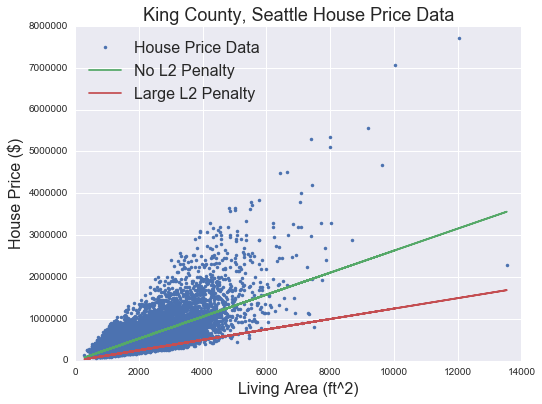

In [11]:
plt.figure(figsize=(8,6))
plt.plot(simple_feature_matrix[:,1],output,'.', label= 'House Price Data')
plt.hold(True)

plt.plot(simple_feature_matrix[:,1], predict_output(simple_feature_matrix, simple_weights_0_penalty),'-', label= 'No L2 Penalty')
plt.plot(simple_feature_matrix[:,1], predict_output(simple_feature_matrix, simple_weights_high_penalty),'-', label= 'Large L2 Penalty')

plt.hold(False)
plt.legend(loc='upper left', fontsize=16)
plt.xlabel('Living Area (ft^2)', fontsize=16)
plt.ylabel('House Price ($)', fontsize=16)
plt.title('King County, Seattle House Price Data', fontsize=18)
plt.axis([0.0, 14000.0, 0.0, 8000000.0])
plt.show()

**Quiz Question: What is the value of the coefficient for sqft_living that you learned with no regularization, rounded to 1 decimal place? What about the one with high regularization?**

In [12]:
print(simple_weights_0_penalty[1])
print(simple_weights_high_penalty[1])

263.024368965
124.572175674


**Quiz Question: Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?**

The model with no L2 penalty

Compute the RSS on the TEST data for the following three sets of weights:

1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

In [13]:
test_pred_weights_0 = predict_output(simple_test_feature_matrix, initial_weights)
RSS_test_weights_0 = sum( (test_output - test_pred_weights_0)**2.0 )

test_pred_no_reg = predict_output(simple_test_feature_matrix, simple_weights_0_penalty)
RSS_test_no_reg = sum( (test_output - test_pred_no_reg)**2.0 )

test_pred_high_reg = predict_output(simple_test_feature_matrix, simple_weights_high_penalty)
RSS_test_high_reg = sum( (test_output - test_pred_high_reg)**2.0 )

**Quiz Question: What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)?**

In [14]:
print(RSS_test_weights_0)
print(RSS_test_no_reg)
print(RSS_test_high_reg)

1.78427328614e+15
2.75723632154e+14
6.9464210149e+14


### Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: [ ‘sqft_living’, ‘sqft_living_15’].

First, create Numpy version of your training and test data with the two features.

In [15]:
model_features = ['sqft_living', 'sqft_living15']
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

First, let’s consider no regularization. Set the L2 penalty to 0.0 and run your ridge regression algorithm. Use the following parameters:

initial_weights = all zeros

step size = 1e-12

max_iterations = 1000

Call the learned weights

In [16]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

l2_penalty = 0.0
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)
multiple_weights_0_penalty

array([  -0.35743483,  243.05416982,   22.41481497])

Next, let’s consider high regularization. Set the L2 penalty to 1e11 and run your ridge regression to learn the weights of the simple model. Use the same parameters as above. Call your weights:

In [17]:
l2_penalty = 1.0e11
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)
multiple_weights_high_penalty

array([  6.74296579,  91.48927365,  78.43658766])

**Quiz Question: What is the value of the coefficient for ‘sqft_living’ that you learned with no regularization, rounded to 1 decimal place? What about the one with high regularization?**

In [18]:
print(multiple_weights_0_penalty[1])
print(multiple_weights_high_penalty[1])

243.054169821
91.4892736471


Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

In [19]:
test_pred_mul_feat_weights_0 = predict_output(test_feature_matrix, initial_weights)
RSS_test_mul_feat_weights_0 = sum( (test_output - test_pred_mul_feat_weights_0)**2.0 )

test_pred_mul_feat_no_reg = predict_output(test_feature_matrix, multiple_weights_0_penalty)
RSS_test_mul_feat_no_reg = sum( (test_output - test_pred_mul_feat_no_reg)**2.0 )

test_pred_mul_feat_high_reg = predict_output(test_feature_matrix, multiple_weights_high_penalty)
RSS_test_mul_feat_high_reg = sum( (test_output - test_pred_mul_feat_high_reg)**2.0 )

**Quiz Question: What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)?**

In [20]:
print(RSS_test_mul_feat_weights_0)
print(RSS_test_mul_feat_no_reg)
print(RSS_test_mul_feat_high_reg)

1.78427328614e+15
2.74067615919e+14
5.00404800501e+14


Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.)

In [21]:
print("Prediction for house 1 using no regularization model: %.2f" % predict_output(test_feature_matrix, multiple_weights_0_penalty)[0])
print("Prediction for house 1 using high regularization model: %.2f" % predict_output(test_feature_matrix, multiple_weights_high_penalty)[0])

Prediction for house 1 using no regularization model: 387465.48
Prediction for house 1 using high regularization model: 270453.53
Prediction error for house 1 using no regularization model: -77465.48
Prediction error for house 1 using high regularization model: 39546.47


**Quiz Question: What's the error in predicting the price of the first house in the test set using the weights learned with no regularization? What about with high regularization?**

In [ ]:
print("Prediction error for house 1 using no regularization model: %.2f" % (test_output[0] - predict_output(test_feature_matrix, multiple_weights_0_penalty)[0]))
print("Prediction error for house 1 using high regularization model: %.2f" % (test_output[0] - predict_output(test_feature_matrix, multiple_weights_high_penalty)[0]))